In [1]:
import pandas as pd
import vectorbt as vbt
from tqdm import tqdm
import matplotlib.pyplot as plt
import empyrical as ep
import requests
import numpy as np

import warnings
warnings.filterwarnings('ignore')

/Users/vkotopoulos/Dev/vkotopoulos/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020



### Loading Data

In [98]:
open = pd.read_csv('binance_usdt_futures_open.csv')
high = pd.read_csv('binance_usdt_futures_high.csv')
low = pd.read_csv('binance_usdt_futures_low.csv')
close = pd.read_csv('binance_usdt_futures_close.csv')
volume = pd.read_csv('binance_usdt_futures_volume.csv')

open['Open time'] = pd.to_datetime(open['Open time'])
open.set_index('Open time', inplace=True)

high['Open time'] = pd.to_datetime(high['Open time'])
high.set_index('Open time', inplace=True)

low['Open time'] = pd.to_datetime(low['Open time'])
low.set_index('Open time', inplace=True)

close['Open time'] = pd.to_datetime(close['Open time'])
close.set_index('Open time', inplace=True)

volume['Open time'] = pd.to_datetime(volume['Open time'])
volume.set_index('Open time', inplace=True)

In [99]:
universe = ['BTCUSDT', 'BNBUSDT', 'ADAUSDT', 'DOGEUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT']
# universe = ['BTCUSDT', 'ETHUSDT']

In [100]:
open = open[universe]
high = high[universe]
low = low[universe]
close = close[universe]
volume = volume[universe]


In [101]:
tmc = pd.read_csv('total_crypto_mcap.csv')
tmc.date = pd.to_datetime(tmc.date, utc=True)
tmc.set_index('date', inplace=True)
tmc = tmc.total_market_cap_in_usd.resample('D').ffill().loc[close.index]

### Computing Indicators

In [102]:
def compute_rolling_beta(asset_returns: pd.DataFrame, benchmark_returns: pd.Series, window: int) -> pd.DataFrame:
    """
    Compute rolling beta for multiple assets relative to a single benchmark.

    Parameters:
    - asset_returns (pd.DataFrame): Return series of multiple assets (columns = assets)
    - benchmark_returns (pd.Series): Return series of the benchmark
    - window (int): Lookback window for rolling calculation

    Returns:
    - pd.DataFrame: Rolling beta values for each asset
    """
    # Align indices
    asset_returns, benchmark_returns = asset_returns.align(benchmark_returns, join='inner', axis=0)

    # Precompute rolling variance of the benchmark
    rolling_var = benchmark_returns.rolling(window).var().shift()

    # Compute rolling covariance of each asset with the benchmark
    rolling_cov = asset_returns.rolling(window).cov(benchmark_returns).shift()

    # Divide each covariance column by the rolling variance (align on index)
    rolling_beta = rolling_cov.div(rolling_var, axis=0)

    return rolling_beta

In [103]:
beta_14d = compute_rolling_beta(close.pct_change(), tmc.pct_change(), 14)

In [104]:
tmc_roc = tmc.pct_change(14)

In [105]:
donchian_upper = close.rolling(7).max().shift()

### Backtesting

In [106]:
tmc_roc_df = pd.DataFrame(index=close.index, columns=close.columns)
for col in close.columns:
    tmc_roc_df[col] = tmc_roc

entries = (np.sign(beta_14d) == np.sign(tmc_roc_df)) & (close > donchian_upper)
exits = (np.sign(beta_14d) != np.sign(tmc_roc_df))

pf = vbt.Portfolio.from_signals(close, entries=entries, exits=exits, freq='D')

In [107]:
# pf.returns().add(1).cumprod().plot()
pfvalue = pf.returns().mean(axis=1).add(1).cumprod().mul(100)
pfreturns = pf.returns().mean(axis=1)

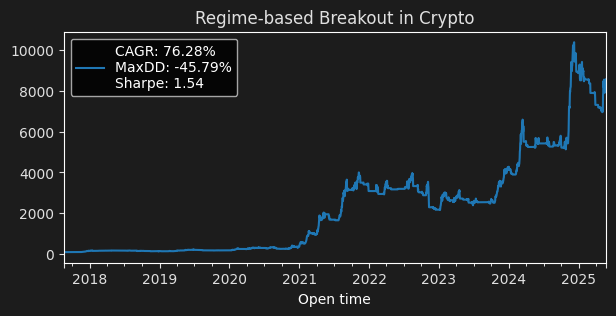

In [110]:
# Plotting results
CLR_BG     = "#1C1C1C"   # dark grey background
CLR_AX     = "#E0E0E0"   # light grey ticks/labels
plt.style.use('dark_background')
pfvalue.plot(color='#1f77b4', figsize=(7, 3))
plt.gca().set_facecolor(CLR_BG)
plt.gcf().set_facecolor(CLR_BG)
plt.legend().set_visible(False)
plt.title('Regime-based Breakout in Crypto', color=CLR_AX)
plt.tick_params(colors=CLR_AX)

# Calculate metrics
sharpe = round(ep.sharpe_ratio(pfreturns, annualization=365), 2)
cagr = round(ep.cagr(pfreturns, annualization=365) * 100, 2)
maxdd = round(ep.max_drawdown(pfreturns) * 100, 2)

# Add metrics to plot legend
plt.legend([f'CAGR: {cagr}%\nMaxDD: {maxdd}%\nSharpe: {sharpe}'])

# Save figure before showing
plt.savefig('./figures/regime_based_breakout_in_crypto.png', bbox_inches='tight', transparent=False, facecolor=CLR_BG)
plt.show()